In [1]:
import csv
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from qucumber.nn_states import DensityMatrix
from qucumber.nn_states import ComplexWaveFunction
from qucumber.callbacks import MetricEvaluator
import qucumber.utils.unitaries as unitaries
import qucumber.utils.training_statistics as ts
import qucumber.utils.cplx as cplx
import qucumber.utils.data as data
from qucumber.observables import ObservableBase, to_pm1
from qucumber.observables.pauli import flip_spin
import qucumber

from qulacs.gate import Pauli

In [16]:
import os
import random
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
from tqdm import tqdm
import itertools

# settings
## warnings
warnings.simplefilter('ignore')

## seaborn layout
sns.set()
sns.set_style("white")

## seed
def seed_settings(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    #torch.manual_seed(seed)
    #qucumber.set_random_seed(seed, cpu=True, gpu=False)

seed_settings(seed=42)

# 1-qubit gate
## pauli X
def X(n_qubit, target_qubit_idx):
    I = np.eye(2)
    local_X = np.array([[0,1],[1,0]])
    if target_qubit_idx==0:
        mat = local_X
    else:
        mat = I
    for i in range(n_qubit-1):
        if i+1==target_qubit_idx:
            mat = np.kron(mat, local_X)
        else:
            mat = np.kron(mat, I)
            
    return mat

## pauli Y
def Y(n_qubit, target_qubit_idx):
    I = np.eye(2)
    local_Y = np.array([[0,-1j], [1j,0]])
    if target_qubit_idx==0:
        mat = local_Y
    else:
        mat = I
    for i in range(n_qubit-1):
        if i+1==target_qubit_idx:
            mat = np.kron(mat, local_Y)
        else:
            mat = np.kron(mat, I)
            
    return mat

## pauli Z
def Z(n_qubit, target_qubit_idx):
    I = np.eye(2)
    local_Z = np.array([[1,0], [0,-1]])
    if target_qubit_idx==0:
        mat = local_Z
    else:
        mat = I
    for i in range(n_qubit-1):
        if i+1==target_qubit_idx:
            mat = np.kron(mat, local_Z)
        else:
            mat = np.kron(mat, I)
            
    return mat

## Hadamard gate
def H(n_qubit, target_qubit_idx):
    I = np.eye(2)
    local_H = np.array([[1,1], [1,-1]]) / np.sqrt(2)
    if target_qubit_idx==0:
        mat = local_H
    else:
        mat = I
    for i in range(n_qubit-1):
        if i+1==target_qubit_idx:
            mat = np.kron(mat, local_H)
        else:
            mat = np.kron(mat, I)
            
    return mat

## S gate
def S(n_qubit, target_qubit_idx):
    I = np.eye(2)
    local_S = np.array([[1,0], [0,1j]])
    if target_qubit_idx==0:
        mat = local_S
    else:
        mat = I
    for i in range(n_qubit-1):
        if i+1==target_qubit_idx:
            mat = np.kron(mat, local_S)
        else:
            mat = np.kron(mat, I)
            
    return mat

## T gate
def T(n_qubit, target_qubit_idx):
    I = np.eye(2)
    local_T = np.array([[1,0], [0,-np.exp(1j*np.pi/4)]])
    if target_qubit_idx==0:
        mat = local_T
    else:
        mat = I
    for i in range(n_qubit-1):
        if i+1==target_qubit_idx:
            mat = np.kron(mat, local_T)
        else:
            mat = np.kron(mat, I)
            
    return mat

## Rx gate
def Rx(n_qubit, target_qubit_idx, theta):
    I = np.eye(2)
    local_Rx = np.array([[np.cos(theta/2),-1j*np.sin(theta/2)], [-1j*np.sin(theta/2),np.cos(theta/2)]])
    if target_qubit_idx==0:
        mat = local_Rx
    else:
        mat = I
    for i in range(n_qubit-1):
        if i+1==target_qubit_idx:
            mat = np.kron(mat, local_Rx)
        else:
            mat = np.kron(mat, I)
            
    return mat

## Ry gate
def Ry(n_qubit, target_qubit_idx, theta):
    I = np.eye(2)
    local_Ry = np.array([[np.cos(theta/2),-np.sin(theta/2)], [-np.sin(theta/2),np.cos(theta/2)]])
    if target_qubit_idx==0:
        mat = local_Ry
    else:
        mat = I
    for i in range(n_qubit-1):
        if i+1==target_qubit_idx:
            mat = np.kron(mat, local_Ry)
        else:
            mat = np.kron(mat, I)
            
    return mat

## Rz gate
def Rz(n_qubit, target_qubit_idx, theta):
    I = np.eye(2)
    local_Rz = np.array([[np.exp(-1j*theta/2),0], [0,np.cos(1j*theta/2)]])
    if target_qubit_idx==0:
        mat = local_Rz
    else:
        mat = I
    for i in range(n_qubit-1):
        if i+1==target_qubit_idx:
            mat = np.kron(mat, local_Rz)
        else:
            mat = np.kron(mat, I)
            
    return mat

# 2-qubit gate
## CX gate
def CX(n_qubit, control_qubit_idx, target_qubit_idx):
    I = np.eye(2)
    ket_0 = np.array([[1],[0]]) 
    ket_1 = np.array([[0],[1]])
    
    mat_00 = ket_0 @ ket_0.T.conjugate() ### |0><0|
    mat_11 = ket_1 @ ket_1.T.conjugate() ### |1><1|
    
    eye_tensor = I
    
    for i in range(n_qubit-2):
        eye_tensor = np.kron(eye_tensor, I)
    
    if control_qubit_idx < target_qubit_idx:
        ### |0><0|　\otimes I \otimes ... \otimes I
        cx_mat_term1 = np.kron(mat_00, eye_tensor)
        ### |1><1| \otimes I ... \otimes X ...
        cx_mat_term2 = np.kron(mat_11, X(n_qubit-1, target_qubit_idx-1))
        
    if control_qubit_idx > target_qubit_idx:
        ### I \otimes ... \otimes I \otimes |0><0|
        cx_mat_term1 = np.kron(eye_tensor, mat_00)
        ### ... \otimes X ... \otimes |1><1|
        cx_mat_term2 = np.kron(X(n_qubit-1, target_qubit_idx), mat_11)
    
    mat = cx_mat_term1 + cx_mat_term2
    
    return mat

## CY gate
def CY(n_qubit, control_qubit_idx, target_qubit_idx):
    I = np.eye(2)
    ket_0 = np.array([[1],[0]]) 
    ket_1 = np.array([[0],[1]])
    
    mat_00 = ket_0 @ ket_0.T.conjugate() ### |0><0|
    mat_11 = ket_1 @ ket_1.T.conjugate() ### |1><1|
    
    eye_tensor = I
    
    for i in range(n_qubit-2):
        eye_tensor = np.kron(eye_tensor, I)
    
    if control_qubit_idx < target_qubit_idx:
        ### |0><0|　\otimes I \otimes ... \otimes I
        cx_mat_term1 = np.kron(mat_00, eye_tensor)
        ### |1><1| \otimes ... \otimes Y ...
        cx_mat_term2 = np.kron(mat_11, Y(n_qubit-1, target_qubit_idx-1))
        
    if control_qubit_idx > target_qubit_idx:
        ### I \otimes ... \otimes I \otimes |0><0|
        cx_mat_term1 = np.kron(eye_tensor, mat_00)
        ### ... \otimes Y ... \otimes |1><1|
        cx_mat_term2 = np.kron(Y(n_qubit-1, target_qubit_idx), mat_11)
    
    mat = cx_mat_term1 + cx_mat_term2
    
    return mat

## CZ gate
def CZ(n_qubit, control_qubit_idx, target_qubit_idx):
    I = np.eye(2)
    ket_0 = np.array([[1],[0]]) 
    ket_1 = np.array([[0],[1]])
    
    mat_00 = ket_0 @ ket_0.T.conjugate() ### |0><0|
    mat_11 = ket_1 @ ket_1.T.conjugate() ### |1><1|
    
    eye_tensor = I
    
    for i in range(n_qubit-2):
        eye_tensor = np.kron(eye_tensor, I)
    
    if control_qubit_idx < target_qubit_idx:
        ### |0><0|　\otimes I \otimes ... \otimes I
        cx_mat_term1 = np.kron(mat_00, eye_tensor)
        ### |1><1| \otimes I ... \otimes Z ...
        cx_mat_term2 = np.kron(mat_11, Z(n_qubit-1, target_qubit_idx-1))
        
    if control_qubit_idx > target_qubit_idx:
        ### I \otimes ... \otimes I \otimes |0><0|
        cx_mat_term1 = np.kron(eye_tensor, mat_00)
        ### ... \otimes Z ... \otimes |1><1|
        cx_mat_term2 = np.kron(Z(n_qubit-1, target_qubit_idx), mat_11)
    
    mat = cx_mat_term1 + cx_mat_term2
    
    return mat

## CH gate
def CH(n_qubit, control_qubit_idx, target_qubit_idx):
    I = np.eye(2)
    ket_0 = np.array([[1],[0]]) 
    ket_1 = np.array([[0],[1]])
    
    mat_00 = ket_0 @ ket_0.T.conjugate() ### |0><0|
    mat_11 = ket_1 @ ket_1.T.conjugate() ### |1><1|
    
    eye_tensor = I
    
    for i in range(n_qubit-2):
        eye_tensor = np.kron(eye_tensor, I)
    
    if control_qubit_idx < target_qubit_idx:
        ### |0><0|　\otimes I \otimes ... \otimes I
        cx_mat_term1 = np.kron(mat_00, eye_tensor)
        ### |1><1| \otimes I ... \otimes H ...
        cx_mat_term2 = np.kron(mat_11, H(n_qubit-1, target_qubit_idx-1))
        
    if control_qubit_idx > target_qubit_idx:
        ### I \otimes ... \otimes I \otimes |0><0|
        cx_mat_term1 = np.kron(eye_tensor, mat_00)
        ### ... \otimes H ... \otimes |1><1|
        cx_mat_term2 = np.kron(H(n_qubit-1, target_qubit_idx), mat_11)
    
    mat = cx_mat_term1 + cx_mat_term2
    
    return mat

## CRx gate
def CRx(n_qubit, control_qubit_idx, target_qubit_idx, theta):
    I = np.eye(2)
    ket_0 = np.array([[1],[0]]) 
    ket_1 = np.array([[0],[1]])
    
    mat_00 = ket_0 @ ket_0.T.conjugate() ### |0><0|
    mat_11 = ket_1 @ ket_1.T.conjugate() ### |1><1|
    
    eye_tensor = I
    
    for i in range(n_qubit-2):
        eye_tensor = np.kron(eye_tensor, I)
    
    if control_qubit_idx < target_qubit_idx:
        ### |0><0|　\otimes I \otimes ... \otimes I
        cx_mat_term1 = np.kron(mat_00, eye_tensor)
        ### |1><1| \otimes I ... \otimes Rx ...
        cx_mat_term2 = np.kron(mat_11, Rx(n_qubit-1, target_qubit_idx-1, theta))
        
    if control_qubit_idx > target_qubit_idx:
        ### I \otimes ... \otimes I \otimes |0><0|
        cx_mat_term1 = np.kron(eye_tensor, mat_00)
        ### ... \otimes Rx ... \otimes |1><1|
        cx_mat_term2 = np.kron(Rx(n_qubit-1, target_qubit_idx, theta), mat_11)
    
    mat = cx_mat_term1 + cx_mat_term2
    
    return mat

## CRy gate
def CRy(n_qubit, control_qubit_idx, target_qubit_idx, theta):
    I = np.eye(2)
    ket_0 = np.array([[1],[0]]) 
    ket_1 = np.array([[0],[1]])
    
    mat_00 = ket_0 @ ket_0.T.conjugate() ### |0><0|
    mat_11 = ket_1 @ ket_1.T.conjugate() ### |1><1|
    
    eye_tensor = I
    
    for i in range(n_qubit-2):
        eye_tensor = np.kron(eye_tensor, I)
    
    if control_qubit_idx < target_qubit_idx:
        ### |0><0|　\otimes I \otimes ... \otimes I
        cx_mat_term1 = np.kron(mat_00, eye_tensor)
        ### |1><1| \otimes I ... \otimes Ry ...
        cx_mat_term2 = np.kron(mat_11, Ry(n_qubit-1, target_qubit_idx-1, theta))
        
    if control_qubit_idx > target_qubit_idx:
        ### I \otimes ... \otimes I \otimes |0><0|
        cx_mat_term1 = np.kron(eye_tensor, mat_00)
        ### ... \otimes Ry ... \otimes |1><1|
        cx_mat_term2 = np.kron(Ry(n_qubit-1, target_qubit_idx, theta), mat_11)
    
    mat = cx_mat_term1 + cx_mat_term2
    
    return mat

## CRz gate
def CRz(n_qubit, control_qubit_idx, target_qubit_idx, theta):
    I = np.eye(2)
    ket_0 = np.array([[1],[0]]) 
    ket_1 = np.array([[0],[1]])
    
    mat_00 = ket_0 @ ket_0.T.conjugate() ### |0><0|
    mat_11 = ket_1 @ ket_1.T.conjugate() ### |1><1|
    
    eye_tensor = I
    
    for i in range(n_qubit-2):
        eye_tensor = np.kron(eye_tensor, I)
    
    if control_qubit_idx < target_qubit_idx:
        ### |0><0|　\otimes I \otimes ... \otimes I
        cx_mat_term1 = np.kron(mat_00, eye_tensor)
        ### |1><1| \otimes I ... \otimes Rz ...
        cx_mat_term2 = np.kron(mat_11, Rz(n_qubit-1, target_qubit_idx-1, theta))
        
    if control_qubit_idx > target_qubit_idx:
        ### I \otimes ... \otimes I \otimes |0><0|
        cx_mat_term1 = np.kron(eye_tensor, mat_00)
        ### ... \otimes Rz ... \otimes |1><1|
        cx_mat_term2 = np.kron(Rz(n_qubit-1, target_qubit_idx, theta), mat_11)
    
    mat = cx_mat_term1 + cx_mat_term2
    
    return mat

## SWAP gate
def SWAP(n_qubit, qubit_idx_1, qubit_idx_2):
    mat = CX(n_qubit, qubit_idx_1, qubit_idx_2) @ CX(n_qubit, qubit_idx_2, qubit_idx_1)
    mat = mat @ CX(n_qubit, qubit_idx_1, qubit_idx_2)
    
    return mat

# 3-qubit gate
## toffoli gate
"""
def toffoli(n_qubit, control_qubit_idx_1, control_qubit_idx_2, target_qubit_idx):
"""

def depolarizing(state, n_qubit, error_rate, target_qubit_idx):
    I = np.eye(2)
    coff_I = (1-error_rate)*I
    
    if target_qubit_idx==0:
        mat = coff_I
    else:
        mat = I
    for i in range(n_qubit-1):
        if i+1==target_qubit_idx:
            mat = np.kron(mat, coff_I)
        else:
            mat = np.kron(mat, I)
            
    depolarizing_term1 = mat @ state
    depolarizing_term2 = X(n_qubit, target_qubit_idx)@state@X(n_qubit, target_qubit_idx) + Y(n_qubit, target_qubit_idx)@state@Y(n_qubit, target_qubit_idx) + Z(n_qubit, target_qubit_idx)@state@Z(n_qubit, target_qubit_idx)
    
    return depolarizing_term1 + (error_rate/3)*depolarizing_term2
    
def unitary(state, n_qubit, theta, target_qubit_idx):
    
    return Rx(n_qubit, target_qubit_idx, theta) @ state @ Rx(n_qubit, target_qubit_idx, theta).T.conjugate()

def init_state(n_qubit, state_name):
    ket_0 = np.array([[1],[0]]) 
    init_state = ket_0
    
    for i in range(2**(n_qubit-1)-1):
        init_state = np.append(init_state, np.array([[0],[0]]), axis=0) # |00...0>
    
    if state_name == "density_matrix":
        init_state_vec = init_state
        init_state = init_state_vec @ init_state_vec.T.conjugate() # |00...0><00...0|
    
    return init_state

def Bell(n_qubit, state_name, error_model, error_rate):
    if state_name == "state_vector":
        if error_model == "ideal":
            state = init_state(n_qubit, state_name)
            state = H(n_qubit,0) @ state
            state = CX(n_qubit,0,1) @ state
    
    if state_name == "density_matrix":
        if error_model == "ideal":
            state = init_state(n_qubit, state_name)
            state = H(n_qubit,0) @ state @ H(n_qubit,0).T.conjugate()
            state = CX(n_qubit,0,1) @ state @ CX(n_qubit,0,1).T.conjugate()
        
        if error_model == "depolarizing":
            state = init_state(n_qubit, state_name)
            state = H(n_qubit,0) @ state @ H(n_qubit,0).T.conjugate()
            state = depolarizing(state, n_qubit, error_rate, 0)
            state = CX(n_qubit,0,1) @ state @ CX(n_qubit,0,1).T.conjugate()
            state = depolarizing(state, n_qubit, error_rate, 0)
            state = depolarizing(state, n_qubit, error_rate, 1)
        
        if error_model == "unitary":
            state = init_state(n_qubit, state_name)
            state = H(n_qubit,0) @ state @ H(n_qubit,0).T.conjugate()
            state = unitary(state, n_qubit, np.sqrt(error_rate), 0)
            state = CX(n_qubit,0,1) @ state @ CX(n_qubit,0,1).T.conjugate()
            state = unitary(state, n_qubit, np.sqrt(error_rate), 0)
            state = unitary(state, n_qubit, np.sqrt(error_rate), 1)
            
        if error_model == "depolarizing&unitary":
            state = init_state(n_qubit, state_name)
            state = H(n_qubit,0) @ state @ H(n_qubit,0).T.conjugate()
            state = depolarizing(state, n_qubit, error_rate, 0)
            state = unitary(state, n_qubit, np.sqrt(error_rate), 0)
            state = CX(n_qubit,0,1) @ state @ CX(n_qubit,0,1).T.conjugate()
            state = depolarizing(state, n_qubit, error_rate, 0)
            state = depolarizing(state, n_qubit, error_rate, 1)
            state = unitary(state, n_qubit, np.sqrt(error_rate), 0)
            state = unitary(state, n_qubit, np.sqrt(error_rate), 1)
            
    return state

In [17]:
# load_model
nn_state_dm_depolarizing = DensityMatrix.autoload("./dm_model_n_pattern_shot=1000_depolarizing.pt", gpu=True)
nn_state_dm_unitary = DensityMatrix.autoload("./dm_model_n_pattern_shot=1000_unitary.pt", gpu=True)
nn_state_dm_depolarizing_unitary = DensityMatrix.autoload("./dm_model_n_pattern_shot=1000_depolarizing&unitary.pt", gpu=True)

nn_state_sv_depolarizing = ComplexWaveFunction.autoload("./sv_model_n_pattern_shot=1000_depolarizing.pt")
nn_state_sv_unitary = ComplexWaveFunction.autoload("./sv_model_n_pattern_shot=1000_unitary.pt")
nn_state_sv_depolarizing_unitary = ComplexWaveFunction.autoload("./sv_model_n_pattern_shot=1000_depolarizing&unitary.pt")

def get_density_matrix(nn_state):
    space = nn_state.generate_hilbert_space()
    Z = nn_state.normalization(space)
    tensor = nn_state.rho(space, space)/Z
    matrix = cplx.numpy(tensor)
    return matrix

def get_max_eigvec(matrix):
    e_val, e_vec = np.linalg.eigh(matrix)
    me_val = e_val[-1]
    me_vec = e_vec[:,-1]
    return me_vec

def get_state_vector(nn_state):
    space = nn_state.generate_hilbert_space()
    Z = nn_state.normalization(space)
    tensor = nn_state.psi(space)/Z
    vector = cplx.numpy(tensor)
    return vector

def observable_XX():
    target_list = [0, 1]
    pauli_index = [1, 1] # 1:X , 2:Y, 3:Z
    gate = Pauli(target_list, pauli_index) # = X_1 X_2
    return gate.get_matrix()

In [ ]:
# depolarizing
ev_100_sampiling_depolarizing_df = pd.read_csv("./depolarizing/ev_n_sampling=100.csv")
ev_1000_sampiling_depolarizing_df = pd.read_csv("./depolarizing/ev_n_sampling=1000.csv")
ev_10000_sampiling_depolarizing_df = pd.read_csv("./depolarizing/ev_n_sampling=10000.csv")
ev_100000_sampiling_depolarizing_df = pd.read_csv("./depolarizing/ev_n_sampling=100000.csv")
ev_1000000_sampiling_depolarizing_df = pd.read_csv("./depolarizing/ev_n_sampling=1000000.csv")

# unitary
ev_100_sampiling_unitary_df = pd.read_csv("./unitary/ev_n_sampling=100.csv")
ev_1000_sampiling_unitary_df = pd.read_csv("./unitary/ev_n_sampling=1000.csv")
ev_10000_sampiling_unitary_df = pd.read_csv("./unitary/ev_n_sampling=10000.csv")
ev_100000_sampiling_unitary_df = pd.read_csv("./unitary/ev_n_sampling=100000.csv")
ev_1000000_sampiling_unitary_df = pd.read_csv("./unitary/ev_n_sampling=1000000.csv")

# depolarizing&unitary
ev_100_sampiling_depolarizing_unitary_df = pd.read_csv("./depolarizing&unitary/ev_n_sampling=100.csv")
ev_1000_sampiling_depolarizing_unitary_df = pd.read_csv("./depolarizing&unitary/ev_n_sampling=1000.csv")
ev_10000_sampiling_depolarizing_unitary_df = pd.read_csv("./depolarizing&unitary/ev_n_sampling=10000.csv")
ev_100000_sampiling_depolarizing_unitary_df = pd.read_csv("./depolarizing&unitary/ev_n_sampling=100000.csv")
ev_1000000_sampiling_depolarizing_unitary_df = pd.read_csv("./depolarizing&unitary/ev_n_sampling=1000000.csv")

vd_ev = np.mean(np.square(1-ev_1000000_sampiling_depolarizing_df["n_copy=2"].values))

## depolarizing error

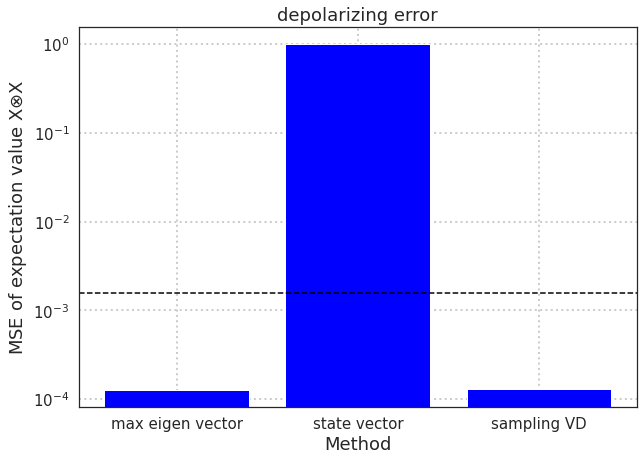

In [54]:
# quauntum state
rho_noisy = Bell(2, "density_matrix", "depolarizing", 0.01)
rho_train = get_density_matrix(nn_state_dm_depolarizing)
vector_train = get_state_vector(nn_state_sv_depolarizing)
max_eigen_vec = get_max_eigvec(rho_train)

# expectation value
noisy_ev = np.trace(observable_XX() @ rho_noisy).real
mev_ev = (np.conjugate(max_eigen_vec).T @ observable_XX() @ max_eigen_vec).real
sv_ev = (np.conjugate(vector_train).T @ observable_XX() @ vector_train).real

x = np.arange(1, 4)
tick_label = ["max eigen vector", "state vector", "sampling VD"]
labels = ["max eigen vector", "state vector", "sampling VD"]

mse_data = [np.square(1-mev_ev), np.square(1-sv_ev), np.mean(np.square(1-ev_1000000_sampiling_depolarizing_df["n_copy=2"].values))]

plt.figure(figsize=(10, 7))
plt.bar(x, mse_data, label=labels,tick_label=tick_label, align="center", color="blue")
plt.axhline(y=np.square(1-noisy_ev), color="black", linestyle='dashed')
#plt.hlines(np.square(1-noisy_ev), 0, 3, "black", linestyles='dashed')
plt.title('depolarizing error', fontsize=18)
plt.xlabel('Method', fontsize=18)
plt.ylabel('MSE of expectation value X$\otimes$X', fontsize=18)
#plt.xticks(x, tick_label)
plt.yscale('log')
plt.tick_params(labelsize=15)
plt.grid(linestyle='dotted', linewidth=2)
#plt.legend(labels, loc='center left', bbox_to_anchor=(1., .5), fontsize=15)
plt.savefig("./figures/varying_method_depolarizing.pdf", bbox_inches='tight')

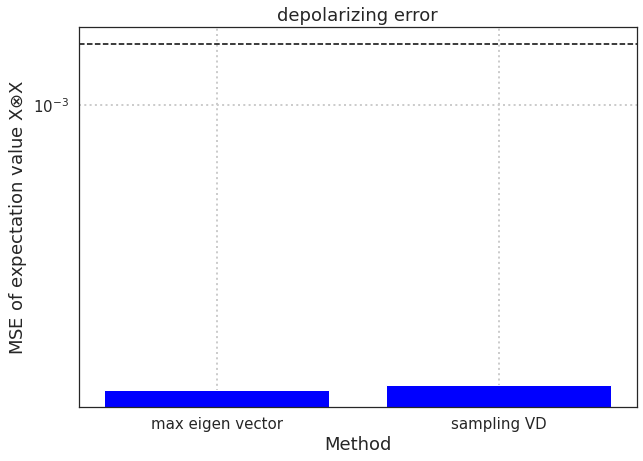

In [66]:
# quauntum state
rho_noisy = Bell(2, "density_matrix", "depolarizing", 0.01)
rho_train = get_density_matrix(nn_state_dm_depolarizing)
vector_train = get_state_vector(nn_state_sv_depolarizing)
max_eigen_vec = get_max_eigvec(rho_train)

# expectation value
noisy_ev = np.trace(observable_XX() @ rho_noisy).real
mev_ev = (np.conjugate(max_eigen_vec).T @ observable_XX() @ max_eigen_vec).real
#sv_ev = (np.conjugate(vector_train).T @ observable_XX() @ vector_train).real

x = np.arange(1, 3)
tick_label = ["max eigen vector", "sampling VD"]
labels = ["max eigen vector", "sampling VD"]

mse_data = [np.square(1-mev_ev), np.mean(np.square(1-ev_1000000_sampiling_depolarizing_df["n_copy=2"].values))]

plt.figure(figsize=(10, 7))
plt.bar(x, mse_data, label=labels,tick_label=tick_label, align="center", color="blue")
plt.axhline(y=np.square(1-noisy_ev), color="black", linestyle='dashed')
#plt.hlines(np.square(1-noisy_ev), 0, 3, "black", linestyles='dashed')
plt.title('depolarizing error', fontsize=18)
plt.xlabel('Method', fontsize=18)
plt.ylabel('MSE of expectation value X$\otimes$X', fontsize=18)
#plt.xticks(x, tick_label)
plt.yscale('log')
plt.tick_params(labelsize=15)
plt.grid(linestyle='dotted', linewidth=2)
#plt.legend(labels, loc='center left', bbox_to_anchor=(1., .5), fontsize=15)
plt.savefig("./figures/varying_method_depolarizing.pdf", bbox_inches='tight')

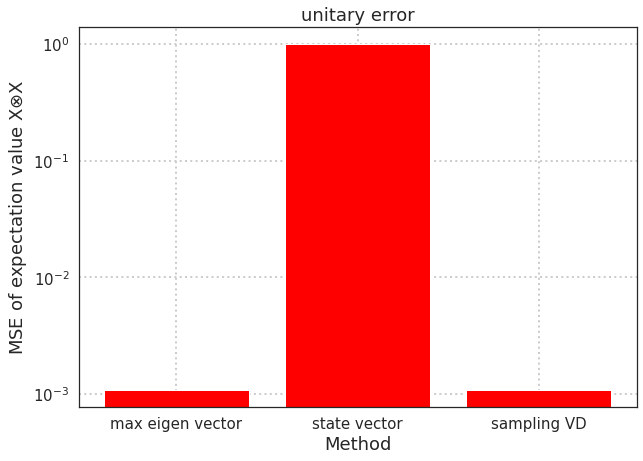

In [59]:
# quauntum state
rho_noisy = Bell(2, "density_matrix", "unitary", 0.01)
rho_train = get_density_matrix(nn_state_dm_unitary)
vector_train = get_state_vector(nn_state_sv_unitary)
max_eigen_vec = get_max_eigvec(rho_train)

# expectation value
noisy_ev = np.trace(observable_XX() @ rho_noisy).real
mev_ev = (np.conjugate(max_eigen_vec).T @ observable_XX() @ max_eigen_vec).real
sv_ev = (np.conjugate(vector_train).T @ observable_XX() @ vector_train).real

x = np.arange(1, 4)
tick_label = ["max eigen vector", "state vector", "sampling VD"]
labels = ["max eigen vector", "state vector", "sampling VD"]

mse_data = [np.square(1-mev_ev), np.square(1-sv_ev), np.mean(np.square(1-ev_1000000_sampiling_unitary_df["n_copy=2"].values))]

plt.figure(figsize=(10, 7))
plt.bar(x, mse_data, label=labels,tick_label=tick_label, align="center", color="red")
plt.axhline(y=np.square(1-noisy_ev), color="black", linestyle='dashed')
#plt.hlines(np.square(1-noisy_ev), 0, 3, "black", linestyles='dashed')
plt.title('unitary error', fontsize=18)
plt.xlabel('Method', fontsize=18)
plt.ylabel('MSE of expectation value X$\otimes$X', fontsize=18)
#plt.xticks(x, tick_label)
plt.yscale('log')
plt.tick_params(labelsize=15)
plt.grid(linestyle='dotted', linewidth=2)
#plt.legend(labels, loc='center left', bbox_to_anchor=(1., .5), fontsize=15)
plt.savefig("./figures/varying_method_unitary.pdf", bbox_inches='tight')

In [60]:
noisy_ev

1.0

In [61]:
rho_noisy

array([[ 4.95016644e-01+3.43486798e-18j, -3.44636352e-19+4.96673327e-02j,
        -3.44636352e-19+4.96673327e-02j,  4.95016644e-01+3.43486798e-18j],
       [ 3.44636352e-19-4.96673327e-02j,  4.98335554e-03+3.45789754e-20j,
         4.98335554e-03+3.45789754e-20j,  3.44636352e-19-4.96673327e-02j],
       [ 3.44636352e-19-4.96673327e-02j,  4.98335554e-03+3.45789754e-20j,
         4.98335554e-03+3.45789754e-20j,  3.44636352e-19-4.96673327e-02j],
       [ 4.95016644e-01+3.43486798e-18j, -3.44636352e-19+4.96673327e-02j,
        -3.44636352e-19+4.96673327e-02j,  4.95016644e-01+3.43486798e-18j]])

In [62]:
observable_XX() @ rho_noisy

array([[ 4.95016644e-01+3.43486798e-18j, -3.44636352e-19+4.96673327e-02j,
        -3.44636352e-19+4.96673327e-02j,  4.95016644e-01+3.43486798e-18j],
       [ 3.44636352e-19-4.96673327e-02j,  4.98335554e-03+3.45789754e-20j,
         4.98335554e-03+3.45789754e-20j,  3.44636352e-19-4.96673327e-02j],
       [ 3.44636352e-19-4.96673327e-02j,  4.98335554e-03+3.45789754e-20j,
         4.98335554e-03+3.45789754e-20j,  3.44636352e-19-4.96673327e-02j],
       [ 4.95016644e-01+3.43486798e-18j, -3.44636352e-19+4.96673327e-02j,
        -3.44636352e-19+4.96673327e-02j,  4.95016644e-01+3.43486798e-18j]])

In [64]:
np.trace(observable_XX() @ rho_noisy)

(1+6.93889390390723e-18j)

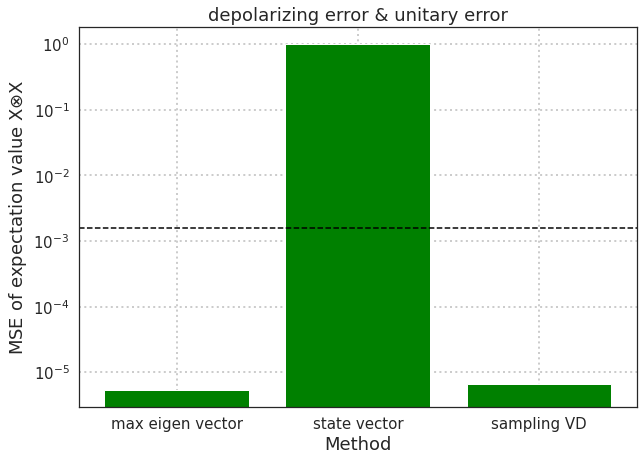

In [58]:
# quauntum state
rho_noisy = Bell(2, "density_matrix", "depolarizing&unitary", 0.01)
rho_train = get_density_matrix(nn_state_dm_depolarizing_unitary)
vector_train = get_state_vector(nn_state_sv_depolarizing_unitary)
max_eigen_vec = get_max_eigvec(rho_train)

# expectation value
noisy_ev = np.trace(observable_XX() @ rho_noisy).real
mev_ev = (np.conjugate(max_eigen_vec).T @ observable_XX() @ max_eigen_vec).real
sv_ev = (np.conjugate(vector_train).T @ observable_XX() @ vector_train).real

x = np.arange(1, 4)
tick_label = ["max eigen vector", "state vector", "sampling VD"]
labels = ["max eigen vector", "state vector", "sampling VD"]

mse_data = [np.square(1-mev_ev), np.square(1-sv_ev), np.mean(np.square(1-ev_1000000_sampiling_depolarizing_unitary_df["n_copy=2"].values))]

plt.figure(figsize=(10, 7))
plt.bar(x, mse_data, label=labels,tick_label=tick_label, align="center", color="green")
plt.axhline(y=np.square(1-noisy_ev), color="black", linestyle='dashed')
#plt.hlines(np.square(1-noisy_ev), 0, 3, "black", linestyles='dashed')
plt.title('depolarizing error & unitary error', fontsize=18)
plt.xlabel('Method', fontsize=18)
plt.ylabel('MSE of expectation value X$\otimes$X', fontsize=18)
#plt.xticks(x, tick_label)
plt.yscale('log')
plt.tick_params(labelsize=15)
plt.grid(linestyle='dotted', linewidth=2)
#plt.legend(labels, loc='center left', bbox_to_anchor=(1., .5), fontsize=15)
plt.savefig("./figures/varying_method_depolarizing&unitary.pdf", bbox_inches='tight')

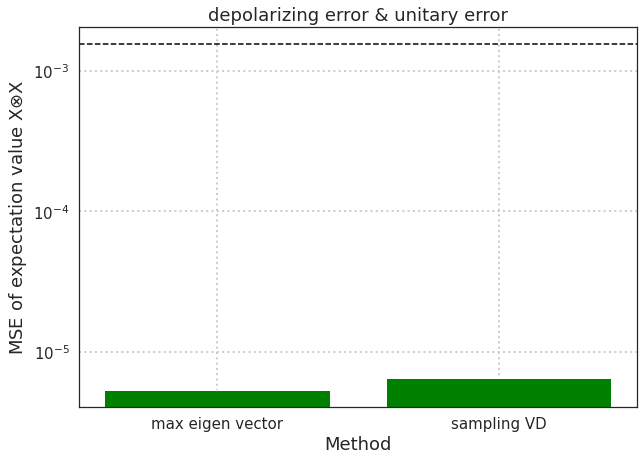

In [67]:
# quauntum state
rho_noisy = Bell(2, "density_matrix", "depolarizing&unitary", 0.01)
rho_train = get_density_matrix(nn_state_dm_depolarizing_unitary)
vector_train = get_state_vector(nn_state_sv_depolarizing_unitary)
max_eigen_vec = get_max_eigvec(rho_train)

# expectation value
noisy_ev = np.trace(observable_XX() @ rho_noisy).real
mev_ev = (np.conjugate(max_eigen_vec).T @ observable_XX() @ max_eigen_vec).real
sv_ev = (np.conjugate(vector_train).T @ observable_XX() @ vector_train).real

x = np.arange(1, 3)
tick_label = ["max eigen vector", "sampling VD"]
labels = ["max eigen vector", "sampling VD"]

mse_data = [np.square(1-mev_ev), np.mean(np.square(1-ev_1000000_sampiling_depolarizing_unitary_df["n_copy=2"].values))]

plt.figure(figsize=(10, 7))
plt.bar(x, mse_data, label=labels,tick_label=tick_label, align="center", color="green")
plt.axhline(y=np.square(1-noisy_ev), color="black", linestyle='dashed')
#plt.hlines(np.square(1-noisy_ev), 0, 3, "black", linestyles='dashed')
plt.title('depolarizing error & unitary error', fontsize=18)
plt.xlabel('Method', fontsize=18)
plt.ylabel('MSE of expectation value X$\otimes$X', fontsize=18)
#plt.xticks(x, tick_label)
plt.yscale('log')
plt.tick_params(labelsize=15)
plt.grid(linestyle='dotted', linewidth=2)
#plt.legend(labels, loc='center left', bbox_to_anchor=(1., .5), fontsize=15)
plt.savefig("./figures/varying_method_depolarizing&unitary.pdf", bbox_inches='tight')